<a href="https://www.kaggle.com/code/natsu18/age-gender-eda-beginners?scriptVersionId=163523836" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this project I will use Tensorflow to analyze the dataset.
The aim is to first analyze the dataset and then build a model from scratch to predict both age and gender from the photo that we have been provided with.

This project is for beginners, I will try to properly explain each and every step and will also link resources wherever possible. 

### About the Dataset:
UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.



<b> If you like this project please follow me on <a href="https://twitter.com/yoii186">Twitter</a> </b>

# Import Libraries

Import some important libraries that we will need throughout the project

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image

#import kornia

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


from IPython.display import display, Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
from termcolor import colored
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

2024-02-20 06:21:14.357123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 06:21:14.357219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 06:21:14.484505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Import Dataset

- I have first defined a `dir_path` that is the link of the directory where our dataset is present
- I have then used `list_dir` method from `os` module, this function gives me a list of all the files present on `dir_path` directory, so I get all the image paths in form of a list in `image_paths` using this function
- After this I use a tensorflow function to convert a single random image to a tensor so that I can find out its shape, we should always know the shape of our dataset, it will be helpful later on when we design a CNN from scratch
- I then defined a dictionary for genders which maps 0 and 1 to genders
- after this I wrote a function to create a dataframe out of our image path. We will need this dataframe for EDA. I did the following in this function:
    - created 3 empty lists and a dataframe
    - used `path.split()` to find individual ages and genders and appended them in empty lists
    - appended a full image path in the `images` list
    - created them as columns and changed the datatypes of `age` and `gender` columns to `int`  
- After that I created `Counter()` for my age and gender columns, this gives us dictionaries of individual values and their counts, although we won't be needing it since we have created a dataframe so any operation that requires us to find counts of individual unique values is possible by either `pandas` or `numpy`

<b> But why did I append the entire path for each image instead of just making a column out of `image_paths`? </b> <br>
-> That is because later on, to print images using this dataframe I will need full paths of these images, so I appended the entire path as it is


In [2]:
dir_path = "/kaggle/input/utkface-new/UTKFace"
image_paths = os.listdir(dir_path)

image_t = tf.image.decode_jpeg(tf.io.read_file(os.path.join(dir_path, image_paths[100])), channels=3)
shape = tf.shape(image_t)
print(f'Height of image: {shape[0]}')
print(f'Width of image: {shape[1]}')

Height of image: 200
Width of image: 200


In [3]:
gender_dict = {0:'Male', 1:'Female'}

In [4]:
def create_df():
    age, gender, images = [], [], []
    df = pd.DataFrame()
    for path in image_paths:
        age.append(path.split('_')[0])
        gender.append(path.split('_')[1])
        images.append(os.path.join(dir_path, path))
    df['images'] = images
    df['age'] = pd.Series(age).astype(int)
    df['gender'] = pd.Series(gender).astype(int)

    return df

df = create_df()

df.head()

,images,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [5]:
df.dtypes

images    object
age        int64
gender     int64
dtype: object

In [6]:
age_c, gender_c = [], []
for path in image_paths:
    age_c.append(path.split('_')[0])
    gender_c.append(path.split('_')[1])
gender_count = dict(Counter(gender_c))
age_count = dict(Counter(age_c))

# Exploratory Data Analysis
There isn't much to explore in this dataset, I will just see the balance of our target features via some count plots and histograms <br>
Making a dataframe above was really helpful since now we can simply do basic EDA.

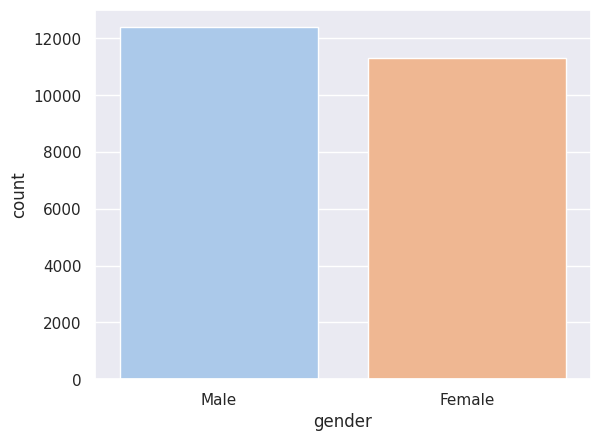

In [7]:
sns.set(font_scale=1)
sns.countplot(data=df, x='gender', palette='pastel')
plt.xticks([0,1],['Male', 'Female'])
plt.show()

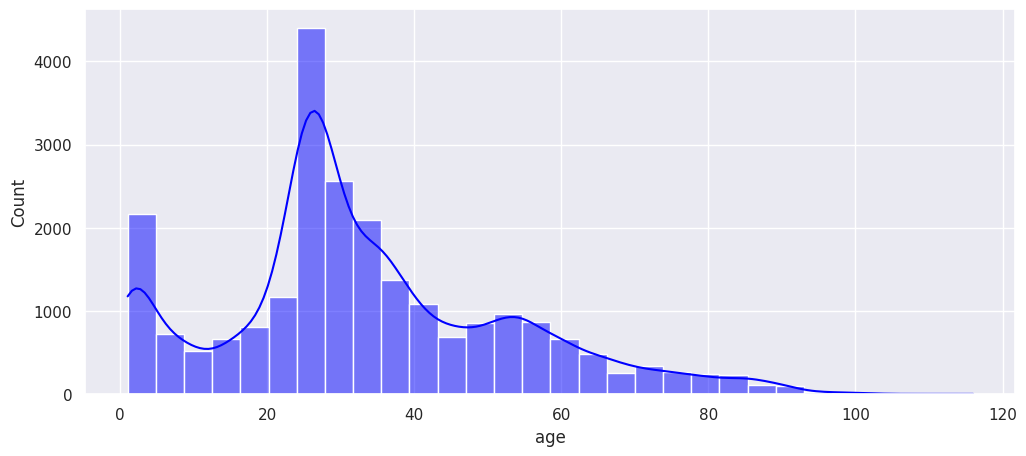

In [8]:
plt.figure(figsize=(12,5))
sns.set(font_scale=1)
sns.histplot(data=df, x='age', color='blue', kde=True, bins=30)
#plt.xticks([0,1],['Male', 'Female'])
plt.show()

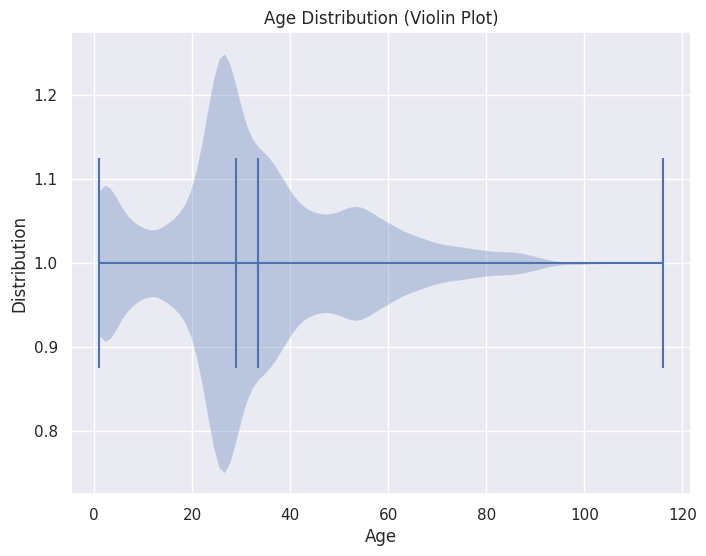

In [9]:
# Violin Plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)
plt.violinplot(df['age'], vert=False, showmeans=True, showextrema=True, showmedians=True)
plt.title('Age Distribution (Violin Plot)')
plt.xlabel('Age')
plt.ylabel('Distribution')
plt.grid(True)
plt.show()

### Results from EDA:
- Genders seem to be pretty much balanced
- Age on the other hand is imbalanced with most of our data being from 1-3 and 20-30 age groups

# Plotting Images
Here we shall plot the first 15 images from our dataset. We do so as follows:
- We will first define the size of our figure
- We then slice our dataframe
- A simple for loop and basic plot functions are used for plotting the images

<b> What is `itertuples()`> </b><br>
This function generates and iterator object of dataframe, basically it returns each row of dataframe as a tuple, hence the use of 4 variables in our for loop below

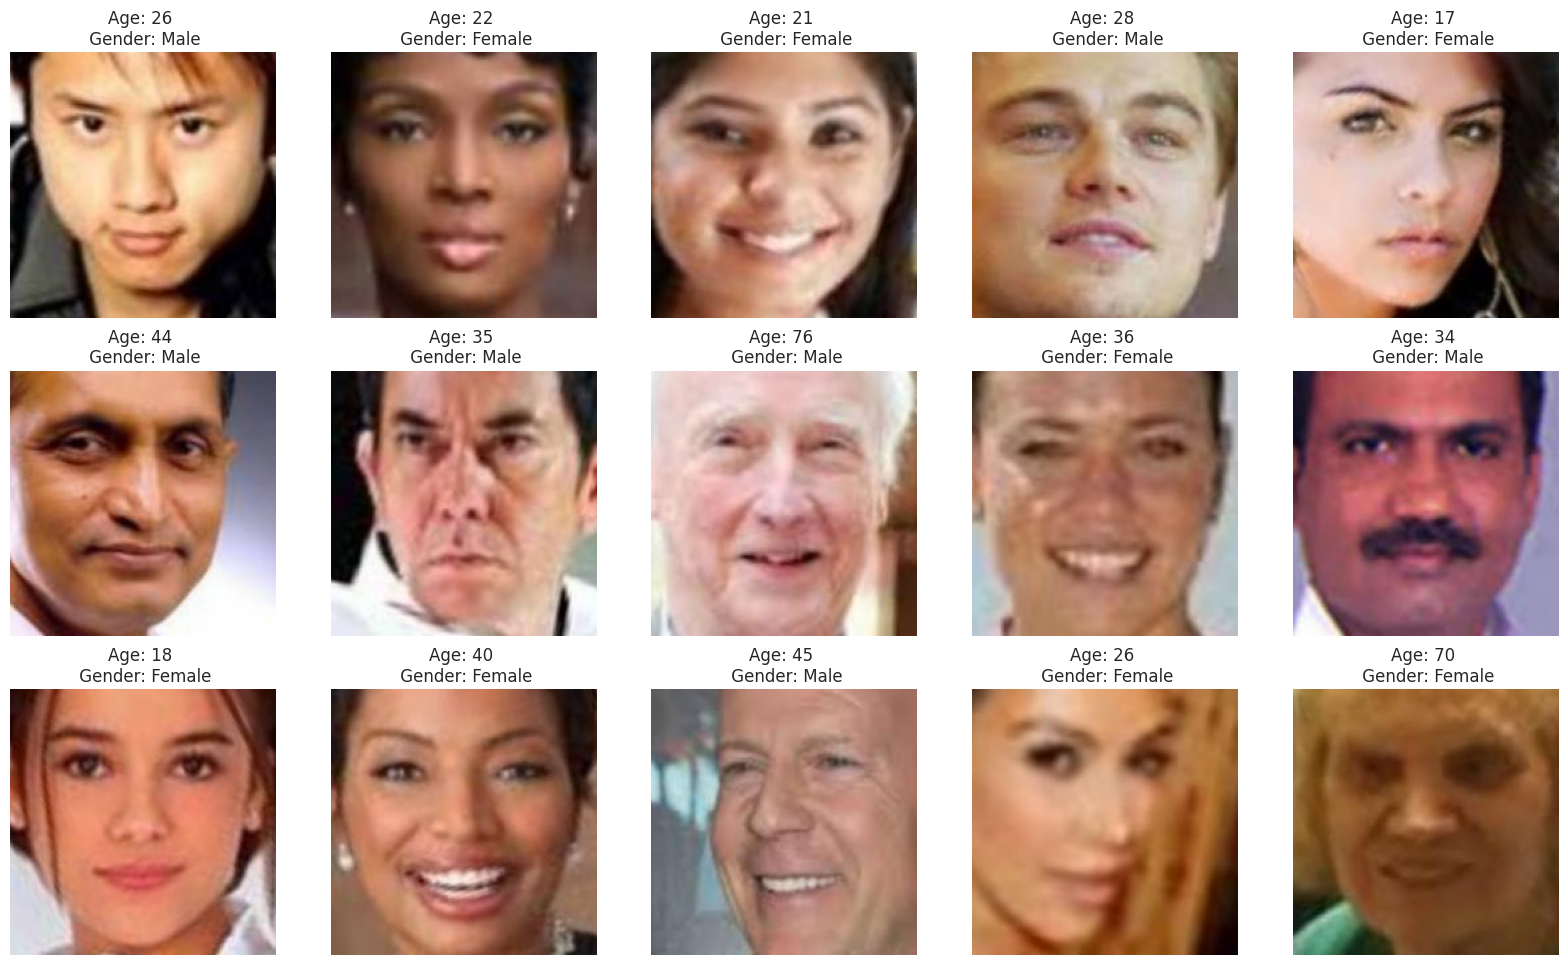

In [10]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file_name, age, gender in files.itertuples():

    plt.subplot(5, 5, index+1)
    img = load_img(file_name)
    plt.imshow(img)
    plt.title(f"Age: {age} \n Gender: {gender_dict[gender]}")
    plt.axis('off')
    #print(type(gender))

# Split Data

- Here we first create a dataset using `tf.data.Dataset.list_files`, we use this because all of our data is in `jpg` format and so we can group them together in a single dataset.
- Then we shuffle this dataset
- After this, I create a `val_size` variable where I decide the size I want my validation dataset to be, I am using 0.2 right now but it can be anything. Cannot use `train_test_split` here
- I used `skip` and `take` to create `train_ds` and `val_ds` 

In [11]:
dataset = tf.data.Dataset.list_files(str(dir_path+'/*.jpg')).shuffle(len(image_paths), reshuffle_each_iteration=False)

val_size = int(len(image_paths)*0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print(f"Size of train data: {len(train_ds)}")
print(f"Size of validation data: {len(val_ds)}")

Size of train data: 18967
Size of validation data: 4741


Now coming to the `process_path` function:<br>
Firstly, <b> why do we even need to define this? </b> <br>
To understand this, you must first know about [Graph Execution](https://www.tensorflow.org/guide/intro_to_graphs). <br>
So what happens is that, when we use `dataset.map(some_func)`, where `some_func` is a function that has tensor operations inside it (like we have in our `process_path` function below, tf will create sub-graphs to run these operations efficiently in the same session as the rest of the graph and there is no need to create a new session at all.

<br> Now coming to what we have defined inside the `process_path`:
- first we separate the file name 
- then we separate our labels and convert them to `int64`
- After this we convert the image to tensor and in the end we return the `img`, `gender` and `age`

In [12]:
def process_path(file_path):
    file = tf.strings.split(file_path, os.path.sep)[-1]
    gender = tf.strings.split(file, '_')[1]
    gender = tf.strings.to_number(gender, tf.int64)

    age = tf.strings.split(file, '_')[0]
    age = tf.strings.to_number(age, tf.int64)

    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    return img, gender, age


- Here we use `map()` function to make sure that tf runs all the operations efficiently without the need of starting separate sessions
- We then shuffle with a buffer size of 100
- Then we divide our datasets to batches 
- After this we use the `prefetch` function 

<br>
Now, what do these functions actually do?
<br>
- We have already looked at `map()`, the `num_parallel_calls` parameter loads multiple datasets in parallel, reducing the overall time needed for files to be opened.
- `prefetch` basically overlaps the data preprocessing step and model execution of a training step, so essentially, we are already reading data for `s+1` step while executiong the `s` step
- `tf.data` builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. While the input pipeline is running, `tf.data` tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.

Please read more on official tensorflow documentation [HERE](https://www.tensorflow.org/guide/data_performance) 

In [13]:
BATCH_SIZE = 32
IMG_SIZE = 128

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

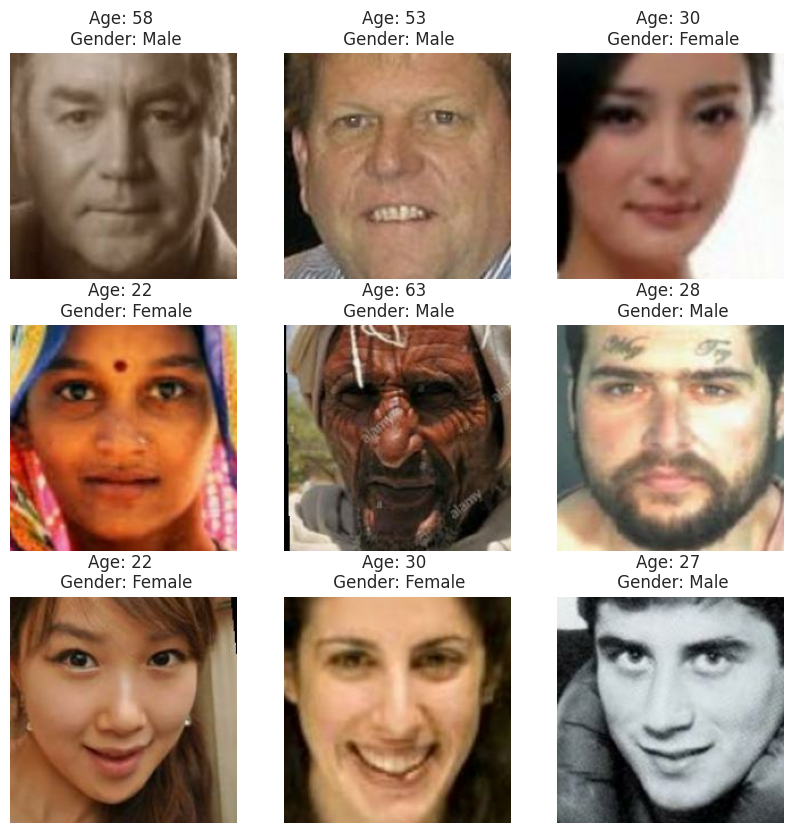

In [14]:
plt.figure(figsize=(10, 10))
for images, gender, age in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Age: {age[i].numpy()} \n Gender: {gender_dict[gender[i].numpy()]}")
        plt.axis("off")